# Chapter 14 - Recurrent Neural Networks

## Setup

In [2]:
import numpy as np
import os


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def sav_fig(fig_id,tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format='png',dpi = 300)

In [3]:
import tensorflow as tf

/Users/alvinchung/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Basic RNNs

## Manual RNN

In [8]:
tf.reset_default_graph()


n_inputs = 3
n_neurons = 5


X0 = tf.placeholder(tf.float32, [None,n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs,n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype = tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1,Wx) + b)

init = tf.global_variables_initializer()


In [9]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [10]:
print(Y0_val)

[[-0.99993277 -0.99867946 -0.98178703 -0.98510361 -0.74405968]
 [-1.         -0.9999938  -0.99993098 -0.99733418  0.48929527]
 [-1.         -1.         -0.99999988 -0.99952543  0.9660722 ]
 [-1.          0.9998132   1.          1.          0.92121643]]


In [11]:
print(Y1_val)

[[-1.         -0.99999905 -1.          0.70943332  0.99999982]
 [ 0.88831192 -0.676135   -0.99995762 -0.44027925  0.69852412]
 [-1.         -0.9353323  -0.99999988 -0.3179203   0.99957496]
 [-0.99999982  0.9999882   0.99191773  0.89175791  0.9815734 ]]


## Using Static_run() TensorFlow's RNN operations

In [12]:
n_inputs = 3
n_neurons = 3

tf.reset_default_graph()


X0 = tf.placeholder(tf.float32, [None,n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell,[X0,X1],
                                               dtype=tf.float32)

Y0, Y1 = output_seqs

In [13]:
init = tf.global_variables_initializer()

In [15]:
X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [17]:
Y0_val

array([[ 0.79882413,  0.66626143, -0.44261435],
       [ 0.99227351,  0.92644733, -0.01748383],
       [ 0.99973106,  0.98554897,  0.41406372],
       [ 0.93540245, -0.91065896, -0.46299636]], dtype=float32)

In [18]:
Y1_val

array([[ 0.99967605,  0.89310133,  0.89986485],
       [ 0.737073  , -0.04748126, -0.06103042],
       [ 0.99837625,  0.77119869,  0.92925137],
       [ 0.65592939,  0.31706586,  0.0367622 ]], dtype=float32)

In [19]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [20]:
show_graph(tf.get_default_graph())

## Packing Sequences

In [23]:
n_steps = 2
n_inputs = 3
n_neurons = 5


In [24]:
tf.reset_default_graph()



X = tf.placeholder(tf.float32,[None, n_steps,n_inputs])
X_seqs = tf.unstack(tf.transpose(X,perm=[1,0,2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell,X_seqs,
                                               dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs),perm=[1,0,2])

In [25]:
init = tf.global_variables_initializer()

In [26]:

X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [27]:
print(outputs_val)

[[[ 0.09289996  0.00348209  0.16847005 -0.72789717  0.93213242]
  [-0.94376922  0.51207995 -0.99969149 -0.99999982  0.99961197]]

 [[-0.30692732  0.43906647 -0.81261241 -0.99929553  0.99843407]
  [-0.0574123  -0.6870352  -0.10410635 -0.65728796  0.61001265]]

 [[-0.62151384  0.73460847 -0.98490363 -0.99999851  0.99996507]
  [-0.74192393  0.12583633 -0.99193466 -0.99999148  0.99675357]]

 [[ 0.89274949  0.99183714 -0.99999118 -0.99984759 -0.99861383]
  [ 0.60319823 -0.06369568 -0.68231696 -0.98251218  0.39711407]]]


In [28]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94376922  0.51207995 -0.99969149 -0.99999982  0.99961197]
 [-0.0574123  -0.6870352  -0.10410635 -0.65728796  0.61001265]
 [-0.74192393  0.12583633 -0.99193466 -0.99999148  0.99675357]
 [ 0.60319823 -0.06369568 -0.68231696 -0.98251218  0.39711407]]


## Using Dynamic_rnn()

In [29]:
n_steps = 2
n_inputs = 3 
n_neurons = 5

In [30]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None,n_steps,n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [31]:
init = tf.global_variables_initializer()

In [32]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [33]:
print(outputs_val)

[[[-0.82791156  0.05331888  0.76376307 -0.91851252 -0.26139072]
  [-0.83827847 -0.9999761   0.98323762 -0.99946094  0.53107631]]

 [[-0.94082445 -0.96300828  0.97279799 -0.9982422  -0.21028227]
  [-0.45247778  0.34626859  0.04091167 -0.33855531  0.40436962]]

 [[-0.98044413 -0.99936181  0.99716502 -0.99996352 -0.15799797]
  [-0.41853535 -0.99900466  0.86396074 -0.99047559  0.66377938]]

 [[ 0.99998158 -0.999919    0.77881461  0.99460208 -0.92199689]
  [ 0.87025845 -0.92295766  0.58758152 -0.56498611  0.73429209]]]


In [34]:
show_graph(tf.get_default_graph())

In [38]:
import numpy as np
import os 
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save figures

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR,"images", CHAPTER_ID, fig_id+".png")
    print("Saving figure", fig_id)
    if tight_layout():
        plt.tight_layout()
    plt.savefig(path,format='png',dpi=300)


# Introduction to OpenAI gym

In [42]:
imp

Next we will load the MsPacman enviroment, version 0.

In [43]:
env = gym.make('MsPacman-v0')

Let's initalize the enviroment by calling reset ```reset()``` method. This returns an observation:

In [44]:
obs = env.reset()

Observations vary depending on the enviroment. In this case it is a RGB image representedas a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other enviroments it may return different objects, as we can see later.

In [45]:
obs.shape

(210, 160, 3)

In [47]:
img = env.render(mode="rgb_array")

Let's plot this image:

<IPython.core.display.Javascript object>


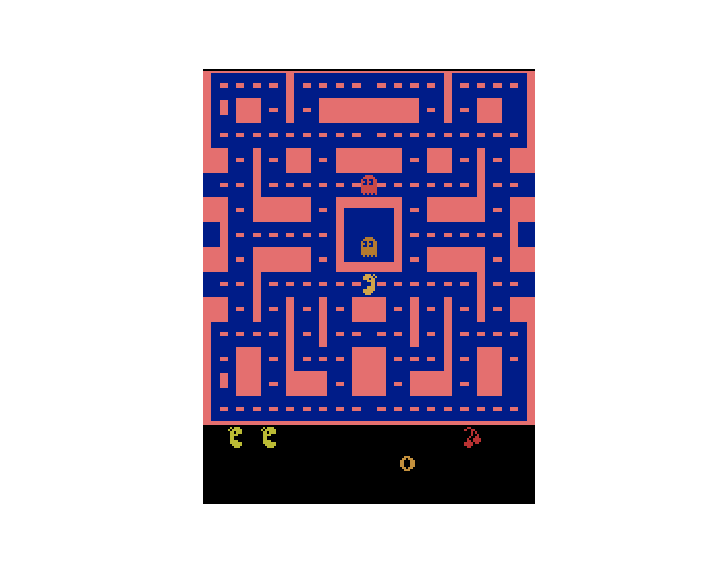

Saving figure MsPacman


TypeError: 'bool' object is not callable

In [49]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("MsPacman")
plt.show()